In [1]:
import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import numpy as np
from pythtb import *
from pythTB_wan import Bloch, K_mesh, Wannier, Lattice
import models

/Users/treycole/Codes/WanPy/dev notebooks


In [48]:
# tight-binding parameters
delta = 1

# # checkerboard
# t0 = 0.4
# tprime = 0.5

# Haldane
t = 1
t2 = -0.4

n_super_cell = 1
model = models.Haldane(delta, t, t2).make_supercell([[n_super_cell, 0], [0, n_super_cell]])

In [49]:
orbs = model.get_orb()
lats = model.get_lat()

print(orbs)
print(lats)

[[0.33333333 0.33333333]
 [0.66666667 0.66666667]]
[[1.        0.       ]
 [0.5       0.8660254]]


In [50]:
orbs[0][0] * lats[0] + orbs[0][1] * lats[1]

array([0.5       , 0.28867513])

In [51]:
pos = orbs @ lats
pos

array([[0.5       , 0.28867513],
       [1.        , 0.57735027]])

In [85]:
# def gen_velocity(model, k_pt):
#     """Generate Hamiltonian for a certain k-point,
#     K-point is given in reduced coordinates!"""

#     kpnt = np.array(k_pt)

#     if k_pt is not None:
#         # if kpnt is just a number then convert it to an array
#         if len(kpnt.shape)==0:
#             kpnt = np.array([kpnt])
#         # check that k-vector is of corect size
#         if kpnt.shape != (model._dim_k,):
#             raise Exception("\n\nk-vector of wrong shape!")
#     else:
#         if model._dim_k!=0:
#             raise Exception("\n\nHave to provide a k-vector!")
        
#     # zero the Hamiltonian matrix
#     if model._nspin == 1:
#         vel = np.zeros((model._dim_k, model._norb, model._norb), dtype=complex)
#     elif model._nspin == 2:
#         vel = np.zeros((model._dim_k, model._norb, 2, model._norb, 2), dtype=complex)

#     # modify diagonal elements
#     # for i in range(model._norb):
#     #     if model._nspin==1:
#     #         vel[i, i] = model._site_energies[i]
#     #     elif model._nspin==2:
#     #         vel[i, :, i, :] = model._site_energies[i]

#     # go over all hoppings
#     for hopping in model._hoppings:
#         # get all data for the hopping parameter
#         if model._nspin == 1:
#             amp = complex(hopping[0])
#         elif model._nspin == 2:
#             amp = np.array(hopping[0], dtype=complex)
#         i = hopping[1]
#         j = hopping[2]
#         # in 0-dim case there is no phase factor
#         if model._dim_k > 0:
#             ind_R = np.array(hopping[3], dtype=float)
#             # vector from one site to another
#             rv = -model._orb[i, :] + model._orb[j, :] + ind_R
#             R = rv @ model.get_lat()
#             # Take only components of vector which are periodic
#             rv = rv[model._per]
#             # Calculate the hopping, see details in info/tb/tb.pdf
#             phase = np.exp((2.0j)*np.pi*np.dot(kpnt,rv))
#             amp = amp*phase
#         # add this hopping into a matrix and also its conjugate
#         if model._nspin == 1:
#             vel[:, i, j] += amp * -R
#             vel[:, j, i] += amp.conjugate() * R
#         elif model._nspin==2:
#             vel[:, i, :, j, :] += amp * -R
#             vel[:, j, :, i, :] += amp.T.conjugate() * R
#     return -1j*vel

def gen_velocity(model, k_pt):
    """Generate Hamiltonian for a certain k-point,
    K-point is given in reduced coordinates!"""

    kpnt = np.array(k_pt)

    if k_pt is not None:
        # if kpnt is just a number then convert it to an array
        if len(kpnt.shape)==0:
            kpnt = np.array([kpnt])
        # check that k-vector is of corect size
        if kpnt.shape != (model._dim_k,):
            raise Exception("\n\nk-vector of wrong shape!")
    else:
        if model._dim_k != 0:
            raise Exception("\n\nHave to provide a k-vector!")
        
    # zero the Hamiltonian matrix
    if model._nspin == 1:
        vel = np.zeros((model._dim_k, model._norb, model._norb), dtype=complex)
    elif model._nspin == 2:
        vel = np.zeros((model._dim_k, model._norb, 2, model._norb, 2), dtype=complex)

    # modify diagonal elements
    # for i in range(model._norb):
    #     if model._nspin==1:
    #         vel[i, i] = model._site_energies[i]
    #     elif model._nspin==2:
    #         vel[i, :, i, :] = model._site_energies[i]

    # go over all hoppings
    for hopping in model._hoppings:
        # get all data for the hopping parameter

        if model._nspin == 1:
            amp = complex(hopping[0])
        elif model._nspin == 2:
            amp = np.array(hopping[0], dtype=complex)

        i = hopping[1]
        j = hopping[2]

        # in 0-dim case there is no phase factor
        if model._dim_k > 0:
            ind_R = np.array(hopping[3], dtype=float)

            # vector from one site to another
            delta_r = ind_R + model._orb[i, :] - model._orb[j, :]
            delta_r_Cart = delta_r @ model.get_lat()
            
            # Take only components of vector which are periodic
            delta_r = delta_r[model._per]

            # Calculate the hopping, see details in info/tb/tb.pdf
            phase = np.exp(-1j * 2 * np.pi * np.dot(kpnt, delta_r))
            amp *= phase

        # add this hopping into a matrix and also its conjugate
        if model._nspin == 1:
            vel[:, i, j] += -1j * amp * delta_r_Cart
            vel[:, j, i] += -1j * amp.conjugate() * -delta_r_Cart

        elif model._nspin == 2:
            vel[:, i, :, j, :] += -1j * amp * delta_r
            vel[:, j, :, i, :] += -1j * amp.T.conjugate() * -delta_r_Cart

    return vel


# def quantum_geom_tens(model, k_vec):
#     n_orb = model.get_num_orbitals()
#     dim_k = k_vec.shape[-1]
    
#     evals, evecs = model.solve_all(k_vec, eig_vectors=True)
#     evecs = np.transpose(evecs, axes=(1, 0, 2)) # [k, n, orb]
#     evals = np.transpose(evals, axes=(1, 0)) # [k, n]
#     n_eigs = evecs.shape[1]

#     QGT = np.zeros((k_vec.shape[0], n_eigs, dim_k, dim_k), dtype=complex)
#     v_k = np.zeros((k_vec.shape[0], dim_k, n_orb, n_orb), dtype=complex)

#     for idx, k_pt in enumerate(k_vec):
#         v_k[idx] = gen_velocity(model, k_pt)
#         for n in range(n_eigs):
#             u_nk = evecs[idx, n, :]
#             for mu in range(dim_k):
#                 for nu in range(dim_k):
#                     for m in range(n_eigs):
#                         u_mk = evecs[idx, m, :]
#                         if n != m: 
#                             # print((u_nk.conj().T @ v_k[idx, mu] @ u_mk).imag.round(10))
#                             # print((u_mk.conj().T @ v_k[idx, nu] @ u_nk) .imag.round(10))

#                             QGT[idx, n, mu, nu] += (
#                                 (u_nk.conj().T @ v_k[idx, mu] @ u_mk) * (u_mk.conj().T @ v_k[idx, nu] @ u_nk)  
#                                 / (evals[idx, n] - evals[idx, m])**2
#                             )

#     return QGT, v_k


def quantum_geom_tens(model, k_vec):
    n_orb = model.get_num_orbitals()
    dim_k = k_vec.shape[-1]
    
    evals, evecs = model.solve_all(k_vec, eig_vectors=True)
    evecs = np.transpose(evecs, axes=(1, 0, 2))  # [k, n, orb]
    evals = np.transpose(evals, axes=(1, 0))  # [k, n]
    n_eigs = evecs.shape[1]

    QGT = np.zeros((k_vec.shape[0], n_eigs, dim_k, dim_k), dtype=complex)
    v_k = np.zeros((k_vec.shape[0], dim_k, n_orb, n_orb), dtype=complex)

    for idx, k_pt in enumerate(k_vec):
        v_k[idx] = gen_velocity(model, k_pt)
        for n in range(n_eigs):
            u_nk = evecs[idx, n, :]
            E_n = evals[idx, n]
            for m in range(n_eigs):
                if n != m:
                    u_mk = evecs[idx, m, :]
                    E_m = evals[idx, m]
                    delta_E = E_n - E_m
                    for mu in range(dim_k):
                        v_nm_mu = u_nk.conj() @ v_k[idx, mu] @ u_mk.T
                        for nu in range(dim_k):
                            v_mn_nu = u_mk.conj() @ v_k[idx, nu] @ u_nk.T
                            QGT[idx, n, mu, nu] += (v_nm_mu * v_mn_nu) / (delta_E ** 2)

    return QGT, v_k

In [76]:
k_mesh = K_mesh(model, 20, 20)
full_mesh = k_mesh.gen_k_mesh(endpoint=True)
full_mesh.shape

(400, 2)

In [77]:
for k_pt in full_mesh:
    # v_k = velocity_op(model, k_pt)
    v_k = gen_velocity(model, k_pt)

    # print(v_k)

In [78]:
wf = wf_array(model, [20, 20])
wf.solve_on_grid([0,0])

wf._wfs.shape

(20, 20, 2, 2)

In [79]:
evals, evecs = model.solve_all(full_mesh, eig_vectors=True)
evecs = np.transpose(evecs, axes=(1, 0, 2)) # [k, n, orb]
evals = np.transpose(evals, axes=(1, 0)) # [k, n]

In [86]:
k_mesh = K_mesh(model, 50, 50)
full_mesh = k_mesh.gen_k_mesh(endpoint=True)
QGT, v_k = quantum_geom_tens(model, full_mesh)

In [87]:
np.amax(QGT.imag)

np.float64(0.9420789135112628)

In [89]:
n_orb = model.get_num_orbitals()

u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
b_curv = u_wfs_full.berry_flux([0])/(2*np.pi)

b_curv2 = np.sum(-2 * QGT.imag, axis=(0, -1, -2))/(2*np.pi)

In [83]:
b_curv

np.float64(1.0000000000000002)

In [90]:
b_curv2

array([-1.23860891e-15, -1.16097876e-15])

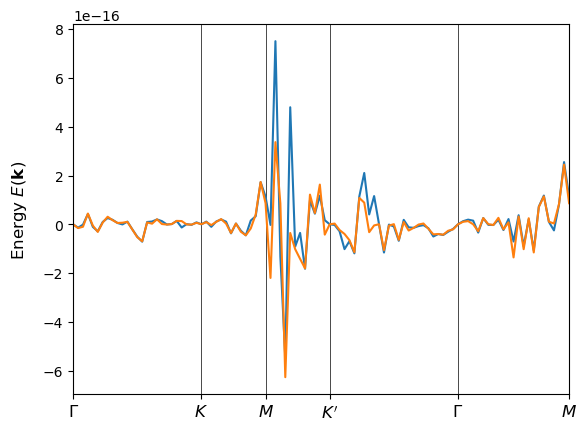

In [91]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

k_path = [[0, 0], [2/3, 1/3], [.5, .5], [1/3, 2/3], [0, 0], [.5, .5]]
k_label = (r'$\Gamma $',r'$K$', r'$M$', r'$K^\prime$', r'$\Gamma $', r'$M$')
(k_vec, k_dist, k_node) = model.k_path(k_path, 101, report=False)

QGT, v_k = quantum_geom_tens(model, k_vec)
QGT_path = np.sum(-2 * QGT.imag, axis=(-1, -2))

ax.set_xlim(0, k_node[-1])
ax.set_xticks(k_node)
for n in range(len(k_node)):
    ax.axvline(x=k_node[n], linewidth=0.5, color='k')
if k_label is not None:
    ax.set_xticklabels(k_label, size=12)

ax.set_ylabel(r"Energy $E(\mathbf{{k}})$", size=12)
ax.yaxis.labelpad = 10

for n in range(QGT.shape[-1]):
    plt.plot(k_dist, QGT_path[:, n] )